In [13]:
#pip install xgboost

In [14]:
from skforecast.recursive import ForecasterRecursiveMultiSeries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [15]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [16]:
df.dropna(inplace=True)

In [17]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [18]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [19]:
df = df.asfreq('ME')  # if data is monthly)

In [20]:
parties= ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']

In [21]:
external=[c for c in df.columns if c not in parties]

In [22]:
cutoff=pd.to_datetime('2025-03-31')
X_en_train=df[parties].loc[df.index <= cutoff]  
X_ex_train=df[external].loc[df.index <= cutoff]
X_en_test=df[parties].loc[df.index > cutoff]  
X_ex_test=df[external].loc[df.index > cutoff]  

In [23]:
X_en_test

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5
2025-07-31,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,4.1


In [24]:
forecaster = ForecasterRecursiveMultiSeries(
    #regressor = RandomForestRegressor(n_estimators=10000, random_state=42),
    #regressor=GradientBoostingRegressor(
    #    n_estimators=500,
    #    learning_rate=0.05,
    #    max_depth=5,
    #    random_state=42
    #),
    #forecaster = ForecasterRecursiveMultiSeries(
    regressor=MLPRegressor(
        hidden_layer_sizes=(128,64),
        activation='relu',
        solver='adam',
        max_iter=10000,
        alpha= 0.1, 
        learning_rate_init= 0.001,
        random_state=42
    ),
    #regressor=Ridge(alpha=1.0),
    #lags = np.arange(1,6),
    #window_features = None,
    #encoding = 'ordinal'  # basic categorical encoding if needed
    #regressor=XGBRegressor(
    #    n_estimators=1000,
    #    learning_rate=0.05,
    #    max_depth=6,
    #    subsample=0.8,
    #    colsample_bytree=0.8,
    #    random_state=42
    #),
    lags = np.arange(1,6)
)
series_dict = {col: X_en_train[col] for col in X_en_train.columns}
forecaster.fit(
    series = series_dict,
    exog = X_ex_train
)

In [25]:
steps = len(X_en_test)

predictions = forecaster.predict(steps = steps, exog = X_ex_test)

In [26]:
pred_wide = predictions.pivot_table(
    index=predictions.index,
    columns='level',
    values='pred'
)
pred_wide

level,Andre,Ap,Frp,Hoyre,KrF,MDG,Rodt,SP,SV,Venstre
2025-04-30,3.327355,26.680004,22.870106,18.816843,2.916724,2.417378,4.691627,5.020989,7.115627,3.989106
2025-05-31,3.386745,26.419570,22.748299,18.998057,2.853886,2.299904,4.618575,4.823344,6.896870,3.741560
2025-06-30,3.421211,26.464828,22.840915,18.735433,2.717469,2.177919,4.533634,4.871247,6.569749,3.439829
2025-07-31,3.382601,26.689937,22.747887,18.877559,2.596646,1.985009,4.315649,4.610377,6.277467,3.221768


In [27]:


metrics = {}
for party in parties:
    y_true = X_en_test[party]
    y_hat = pred_wide[party]
    
    metrics[party] = {
        'MSE': mean_squared_error(y_true, y_hat),
        'R2': r2_score(y_true, y_hat),
        'MedianAE': median_absolute_error(y_true, y_hat)
    }

# Optional: convert to DataFrame for nicer display
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

              MSE         R2  MedianAE
Ap       2.683165 -29.664747  1.627584
Hoyre    6.027586  -0.540843  1.759295
Frp      4.449721 -13.740276  1.994607
SV       1.120270  -1.358464  0.572939
SP       1.743377  -7.635925  1.277833
KrF      0.508247 -10.958764  0.674734
Venstre  0.861388  -7.613881  0.709306
MDG      0.899266  -9.983402  0.752352
Rodt     1.440757  -3.925665  1.132888
Andre    0.544287  -6.572690  0.645022


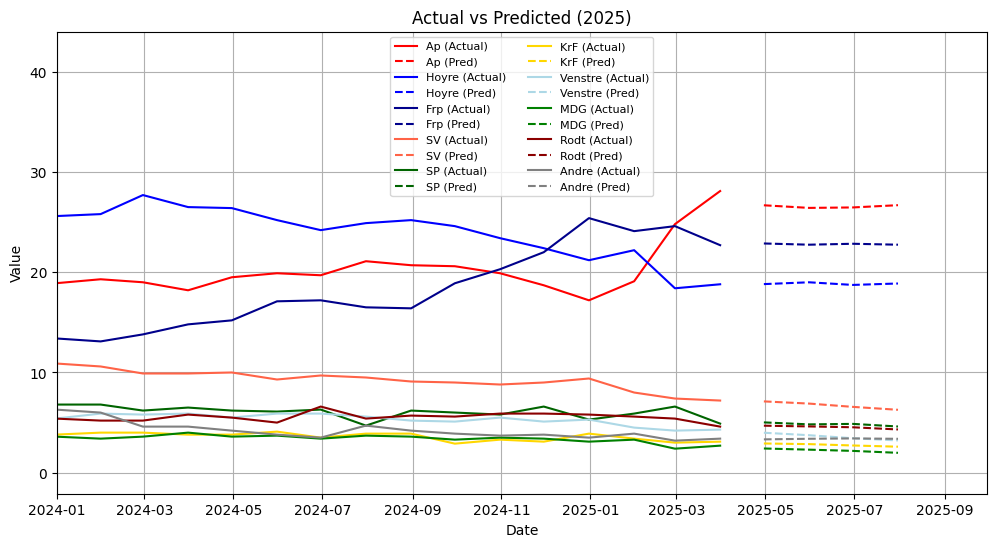

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Color map
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party, color in colors.items():
    # Actual data
    plt.plot(X_en_train.index, X_en_train[party], label=f'{party} (Actual)', color=color, linestyle='-')
    
    # Predictions (wide format)
    plt.plot(pred_wide.index, pred_wide[party], 
             label=f'{party} (Pred)', color=color, linestyle='--')

# Axis limits for 2025
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2025-09-30'))

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted (2025)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from itertools import product
import numpy as np

param_grid = {
    'hidden_layer_sizes': [(32,),(64,), (64,32), (128,64), (264,128)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.00001,0.0001, 0.001, 0.01,0.1,1],
    'learning_rate_init': [0.001, 0.01]
}

best_params = None
best_mse = float('inf')

for hls, act, alpha, lr in product(
    param_grid['hidden_layer_sizes'],
    param_grid['activation'],
    param_grid['alpha'],
    param_grid['learning_rate_init']
):
    forecaster = ForecasterRecursiveMultiSeries(
        regressor=MLPRegressor(
            hidden_layer_sizes=hls,
            activation=act,
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=500,
            random_state=42
        ),
        lags=np.arange(1, 12),
        window_features=None,
        encoding='ordinal'
    )
    series_dict = {col: X_en_train[col] for col in X_en_train.columns}
    forecaster.fit(series=series_dict, exog=X_ex_train)
    
    steps = len(X_en_test)
    y_pred = forecaster.predict(steps=steps, exog=X_ex_test)
    #print(y_pred)
    # Convert to DataFrame
    y_pred_df = y_pred.pivot_table(
    index=predictions.index,
    columns='level',
    values='pred'
    )
    #y_pred_df = pd.DataFrame(y_pred['pred'], index=X_en_test.index, columns=parties)
    
    # Mean MSE across all parties
    mse = np.mean([mean_squared_error(X_en_test[party], y_pred_df[party]) for party in parties])
    
    if mse < best_mse:
        best_mse = mse
        best_params = {'hidden_layer_sizes': hls, 'activation': act, 'alpha': alpha, 'learning_rate_init': lr}

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
